# Факторизация за $O(\sqrt[4]{n})$

Наука умеет раскладывать целые числа на множители за $O(n^\frac{1}{4})$. Алгоритм рандомизированный, поэтому нам сначала понадобится один факт из теорвера.

## Парадокс дней рождений

Пусть $f(n, d)$ это вероятность того, что в группе из $n$ человек ни у кого не совпали дни рождения.
Будем считать, что дни рождения распределены независимо и равномерно в промежутке от $1$ до $d$.

$$f(n, d) = (1-\frac{1}{d}) \times (1-\frac{2}{d}) \times ... \times (1-\frac{n-1}{d})$$

Попытаемся оценить $f$:

$$
\begin{align}
  \begin{aligned}
    e^x & = 1 + x + \frac{x^2}{2!} + \ldots & \text{(ряд Тейлора для экспоненты)} \\
    & \simeq 1 + x & \text{(аппроксимация для $|x| \ll 1$)} \\
    e^{-\frac{n}{d}} & \simeq 1 - \frac{n}{d} & \text{(подставим $\frac{n}{d} \ll 1$)} \\
    f(n, d) & \simeq e^{-\frac{1}{d}} \times e^{-\frac{2}{d}} \times \ldots \times e^{-\frac{n-1}{d}} & \\
    & = e^{-\frac{n(n-1)}{2d}} & \\
    & \simeq e^{-\frac{n^2}{2d}} & \\
  \end{aligned}
\end{align}
$$

Из формулы более-менее понятно, что вероятность $\frac{1}{2}$ достигается при $n \approx \sqrt{d}$ и в этой точке изменяется быстро. Для самого алгоритма нам понадобится следующее:

**Утверждение**. В мультимножество нужно добавить $O(\sqrt{n})$ случайных чисел от 1 до n, чтобы какие-то два совпали.

Если вы не доверяете математике, посмотрите на графики: 

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [63]:
def f(n, d):
    p = 1
    for x in range(1, n):
        p *= 1-x/d
    return p

def g(n, d):
    return 2.71**(-0.5 * n**2 / d)

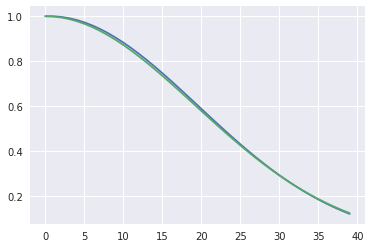

In [64]:
exact = [f(n, 365) for n in range(40)]
approx = [g(n, 365) for n in range(40)]
plt.plot(exact)
plt.plot(approx)
plt.show()

На графике две линии, если не видно, — аппроксимация настолько хороша. Чтобы продемонстрировать $n \approx \sqrt{d}$, построим такую же для больших чисел и перейдём в логарифмический масштаб.

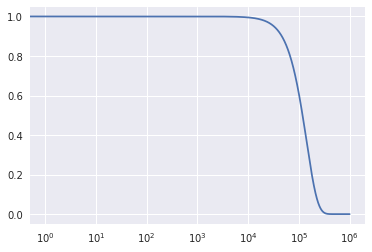

In [75]:
approx = [g(n, 10**10) for n in range(10**6)]
plt.xscale('log')
plt.plot(approx)
plt.show()

## $\rho$-алгоритм Полларда

Итак, мы хотим факторизовать число $n$. Предположим, что $n = p q$ и $p \approx q$. Понятно, что труднее случая, наверное, нет. Алгоритм итеративно ищет наименьший делитель и сводит задачу к как минимум в два раза меньшей.

Возьмём произвольную «достаточно случайную» с точки зрения ТЧ функцию. Например $f(x) = (x+1)^2 \mod n$.

Как выглядит граф, в котором из вершины есть единственное ребро $x \to f(x)$? Такой граф называется *функциональным*. Если в нём нарисовать «траекторию» произвольного элемента, — какой-то путь, превращающийся в цикл, — то получится что-то похожее на букву $\rho$ (ро). Алгоритм из-за этого так и назван.

Рассмотрим траекторию какого-нибудь элемента $x_0$: {$x_0$, $f(x_0)$, $f(f(x_0))$, $\ldots$}. Теперь сделаем из неё новую последовательность, взяв каждый элемент по модулю $p$ — наименьшего из простых делителей $n$. 

**Утверждение**. Ожидаемая длина цикла в этой последовательности $O(\sqrt[4]{n})$.

*Доказательство:* так как $p$ — меньший делитель, то $p \leq \sqrt{n}$. Теперь просто подставим в предыдущее утверждение: в множество нужно добавить $O(\sqrt{p}) = O(\sqrt[4]{n})$ элементов, чтобы какие-то два совпали, а значит последовательность зациклилась.

Если мы найдём цикл в такой последовательности (то есть такие $i$ и $j$, что $f^i(x_0) \equiv f^j(x_0)$), то мы можем восстановить какой-то делитель $n$, а именно $\gcd(|f^i(x_0) - f^j(x_0)|, n)$ — это число меньше $n$ и делится на $p$.

Алгоритм по сути находит цикл в этой последовательности, используя для этого стандартный алгоритм («черепаха и заяц»): будем поддерживать два удаляющиеся друг от друга указателя $i$ и $j$ ($i = 2j$) и проверять, что $f^i(x_0) \equiv f^j(x_0) \pmod p$, что эквивалентно проверке $\gcd(|f^i(x_0) - f^j(x_0)|, n) > 1$.

In [5]:
from math import gcd
from random import randint

In [6]:
def find_divisor(n, seed = 1, f = lambda x: (x+1)**2):
    x = y = seed
    d = 1
    while d == 1:
        x = f(f(x)) % n
        y = f(y) % n
        d = gcd(abs(x-y), n)
    return d

In [7]:
n = 3*5*7 # = 105
print([find_divisor(n, seed=i) for i in range(n)])

[3, 21, 7, 21, 21, 21, 3, 3, 7, 21, 21, 7, 3, 3, 21, 21, 21, 7, 21, 3, 3, 3, 21, 7, 21, 21, 21, 3, 3, 7, 21, 21, 7, 3, 3, 21, 21, 21, 7, 21, 3, 3, 3, 21, 7, 21, 21, 21, 3, 3, 7, 21, 21, 7, 3, 3, 21, 21, 21, 7, 21, 3, 3, 3, 21, 7, 21, 21, 21, 3, 3, 7, 21, 21, 7, 3, 3, 21, 21, 21, 7, 21, 3, 3, 3, 21, 7, 21, 21, 21, 3, 3, 7, 21, 21, 7, 3, 3, 21, 21, 21, 7, 21, 3, 3]


In [8]:
n = (10**9+7)*(10**9+9)
print([find_divisor(n, seed=randint(1, n)) for _ in range(20)])

[1000000007, 1000000009, 1000000009, 1000000009, 1000000009, 1000000009, 1000000007, 1000000009, 1000000009, 1000000009, 1000000007, 1000000009, 1000000007, 1000000009, 1000000009, 1000000009, 1000000009, 1000000009, 1000000007, 1000000009]


Так как алгоритм рандомизированный, при полной реализации нужно учитывать разные детали. Например, что иногда делитель не находится (нужно запускать несколько раз), или что при попытке факторизовать простое число он будет работать за $O(\sqrt{n})$ (нужно добавить отсечение по времени).

##  Разное

Формально, мы показали, что алгоритм работает за $O(\sqrt[4]{n} \log n)$ за счёт поиска $\gcd$, но сложной теорией чисел можно доказать, что этого логарифма в асимптотике на самом деле нет. 

Пародокс дней рождения также можно использовать при подсчёте вероятности коллизии при хэшировании. Хороший модуль должен быть не менее квадрата количества хэшей, а чего-то вроде $5 n^2$ уже почти всегда достаточно.